# Exercícios - Redes de Petri e Algoritmo Alpha

Por Miguel Zanchettin de Oliveira.


### Implementação do algoritmo

In [1]:
class AlgoritmoAlpha:

    log: list[str]

    def __init__(self) -> None:
        pass
    
    @staticmethod
    def _get_nodes(log):
        nodes = [_ for _ in ''.join([trace for trace in log])]
        nodes = list(set(nodes))
        nodes.sort()
        return nodes
    
    @staticmethod
    def _get_inputs(log):
        inputs = [trace[0] for trace in log]
        inputs = list(set(inputs))
        inputs.sort()
        return inputs
    
    @staticmethod
    def _get_outputs(log):
        outputs = [trace[-1] for trace in log]
        outputs = list(set(outputs))
        outputs.sort()
        return outputs

    @staticmethod
    def _get_edges(log):
        edges = [
                (trace[index - 1], trace[index]) 
                for trace in log 
                for index, _ in enumerate(trace) 
                if (index - 1) >= 0
                ]
        edges = list(set(edges))
        edges.sort()
        return edges

    @staticmethod
    def _get_relationship_matrix(nodes, edges):
        relations = []
        for i in nodes:
            row = []
            for j in nodes:
                if i == j:
                    rel = '#' 
                elif (i, j) in edges and (j, i) not in edges:
                    rel = '>'
                elif (i, j) not in edges and (j, i) in edges:
                    rel = '<'
                elif (i, j) in edges and (j, i) in edges:
                    rel = '|'
                else:
                    rel = '#'
                row.append(rel)
            relations.append(row)
        return relations
    
    @staticmethod
    def _transpose_matrix(matrix):
        return [*zip(*matrix)]
    
    @staticmethod
    def _get_regular_cases(nodes, relationship_matrix):
        regular_cases = [
                        ([iName], [jName]) 
                        for i, iName in enumerate(nodes) 
                        for j, jName in enumerate(nodes) 
                        if relationship_matrix[i][j] == '>'
                        ]
        return regular_cases
    
    @staticmethod
    def _get_more_than_one_origin(nodes, relationship_matrix_T):
        more_than_one_origin = [

                                    (
                                        [
                                            jName 
                                            for j, jName in enumerate(nodes) 
                                            if relationship_matrix_T[i][j] == '>'
                                        ]
                                        , [iName]
                                      ) 
                                    for i, iName in enumerate(nodes) 
                                    if len(
                                        [
                                            j 
                                            for j, _ in enumerate(nodes) 
                                            if relationship_matrix_T[i][j] == '>'
                                        ]
                                    ) > 1

                                ]
        
        return more_than_one_origin
    
    @staticmethod
    def _get_more_than_one_destination(nodes, relationship_matrix):
        more_than_one_destinations = [
                                        (
                                            [iName], 
                                            [
                                                jName 
                                                for j, jName in enumerate(nodes) 
                                                if relationship_matrix[i][j] == '>'
                                            ]
                                        ) 
                                        for i, iName in enumerate(nodes)
                                        if len(
                                            [
                                                j 
                                                for j, _ in enumerate(nodes) 
                                                if relationship_matrix[i][j] == '>'
                                            ]
                                        ) > 1
                                    ]
        return more_than_one_destinations
    
    @staticmethod
    def _remove_parallel_origin(more_than_one_origin, log):
        tmp = more_than_one_origin.copy()
        for node in tmp:
            candidate = False
            for trace in log:
                if ''.join([_ for _ in node[0]]) in trace \
                and ''.join([_ for _ in node[1]]) in trace:
                    candidate = True
            if candidate:
                tmp.remove(node)
        return tmp
    
    @staticmethod
    def _remove_parallel_destinations(more_than_one_destinations, log):
        tmp = more_than_one_destinations.copy()
        for node in tmp:
            candidate = False
            for trace in log:
                if ''.join([_ for _ in node[0]]) in trace \
                and ''.join([_ for _ in node[1]]) in trace:
                    candidate = True
            if candidate:
                tmp.remove(node)
        return tmp
    
    @staticmethod
    def _handle_multiplaces(more_than_one_origin):
        origins = []
        for origin in more_than_one_origin:
            candidate = True
            for item in origins:
                if origin[0] == item[0]:
                    candidate = False
                    item[1].extend(origin[1])
            if candidate:
                origins.append(origin)
        return origins
    
    @staticmethod
    def _get_raw_connections(regular_cases, 
                             more_than_one_origin, 
                             more_than_one_destinations):
        raw_connections = []
        raw_connections.extend(regular_cases)
        raw_connections.extend(more_than_one_origin)
        raw_connections.extend(more_than_one_destinations)
        return raw_connections

    @staticmethod
    def _get_connections(raw_connections, 
                         more_than_one_origin, 
                         more_than_one_destinations):
        
        connections = []
        connections.extend(more_than_one_origin)
        connections.extend(more_than_one_destinations)

        # Append only cases that arent in 
        #  more_than_one_origin
        #  and  more_than_one_destinations
        for raw in raw_connections:
            candidate = True
            for con in connections:    
                if set(raw[0]).issubset(con[0]) \
                and set(raw[1]).issubset(con[1]):
                    candidate = False
            if candidate:
                connections.append(raw)

        return connections
    
    def fit(self, log):
        
        self.log = log

        nodes = self._get_nodes(self.log)
        inputs = self._get_inputs(self.log)
        outputs = self._get_outputs(self.log)
        edges = self._get_edges(self.log)
        
        relationship_matrix = self._get_relationship_matrix(nodes, edges)
        relationship_matrix_T = self._transpose_matrix(relationship_matrix)

        regular_cases = self._get_regular_cases(nodes, relationship_matrix)
        
        more_than_one_origin = self._get_more_than_one_origin(nodes, relationship_matrix_T)
        more_than_one_origin = self._remove_parallel_origin(more_than_one_origin, log)
        more_than_one_origin = self._handle_multiplaces(more_than_one_origin)

        more_than_one_destination = self._get_more_than_one_destination(nodes, relationship_matrix)
        more_than_one_destination = self._remove_parallel_destinations(more_than_one_destination, log)

        raw_connections = self._get_raw_connections(regular_cases, more_than_one_origin, more_than_one_destination)
        connections = self._get_connections(raw_connections, more_than_one_origin, more_than_one_destination)

        self.relationship_matrix = relationship_matrix
        self.connections = connections
        self.inputs = inputs
        self.outputs = outputs
        self.edges = edges
        self.nodes = nodes

        pass

    def summary(self):
        
        n = 100

        print('=' * n)
        print(' Algoritmo Alpha')
        print('=' * n)

        print(f' Inputs: ')
        print(f' - {self.inputs}')

        print(f' Events:')
        print(f' - {self.nodes}')
        
        print(f' Places:')
        for _ in self.connections:
            print(f' - {_}')

        print(f' Outputs:')
        print(f' - {self.outputs}')

        print(' Relationship matrix: ')
        nos = '    '.join(self.nodes)
        print(f'       {nos}')
        for i, row in enumerate(self.relationship_matrix):
            print(f'   {self.nodes[i]} {row}')

        print('-' * n)
        print(' By Miguel Zanchettin')
        print('=' * n)

        pass


### Teste considerando exemplo do slide

In [2]:

# Log do ultimo exemplo 
log = []
log.extend(['ABEF' for _ in range(2)])
log.extend(['ABECDBF' for _ in range(3)])
log.extend(['ABCEDBF' for _ in range(2)]) 
log.extend(['ABCDEBF' for _ in range(4)]) 
log.extend(['AEBCDBF' for _ in range(3)]) 

alpha = AlgoritmoAlpha()
alpha.fit(log)
alpha.summary()

 Algoritmo Alpha
 Inputs: 
 - ['A']
 Events:
 - ['A', 'B', 'C', 'D', 'E', 'F']
 Places:
 - (['A', 'D'], ['B'])
 - (['B'], ['C', 'F'])
 - (['A'], ['E'])
 - (['C'], ['D'])
 - (['E'], ['F'])
 Outputs:
 - ['F']
 Relationship matrix: 
       A    B    C    D    E    F
   A ['#', '>', '#', '#', '>', '#']
   B ['<', '#', '>', '<', '|', '>']
   C ['#', '<', '#', '>', '|', '#']
   D ['#', '>', '<', '#', '|', '#']
   E ['<', '|', '|', '|', '#', '>']
   F ['#', '<', '#', '#', '<', '#']
----------------------------------------------------------------------------------------------------
 By Miguel Zanchettin



> ### Exercício 01 
> 
> Considere o seguinte log de eventos. Utilize o algoritmo $\alpha$ para descobrir o modelo correspondente em rede de Petri.
>
> W = ABDEHJ, ABEDHJ, ABEDHGCFJ, ABEDHGBDEHJ, ACFJ, ACFGCFJ.

In [3]:
W = ['ABDEHJ', 'ABEDHJ', 'ABEDHGCFJ', 'ABEDHGBDEHJ', 'ACFJ', 'ACFGCFJ']

alpha = AlgoritmoAlpha()
alpha.fit(W)
alpha.summary()


 Algoritmo Alpha
 Inputs: 
 - ['A']
 Events:
 - ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J']
 Places:
 - (['A', 'G'], ['B', 'C'])
 - (['F', 'H'], ['G', 'J'])
 - (['A'], ['B', 'C'])
 - (['F'], ['G', 'J'])
 - (['G'], ['B', 'C'])
 - (['H'], ['G', 'J'])
 - (['B'], ['D'])
 - (['B'], ['E'])
 - (['C'], ['F'])
 - (['D'], ['H'])
 - (['E'], ['H'])
 Outputs:
 - ['J']
 Relationship matrix: 
       A    B    C    D    E    F    G    H    J
   A ['#', '>', '>', '#', '#', '#', '#', '#', '#']
   B ['<', '#', '#', '>', '>', '#', '<', '#', '#']
   C ['<', '#', '#', '#', '#', '>', '<', '#', '#']
   D ['#', '<', '#', '#', '|', '#', '#', '>', '#']
   E ['#', '<', '#', '|', '#', '#', '#', '>', '#']
   F ['#', '#', '<', '#', '#', '#', '>', '#', '>']
   G ['#', '>', '>', '#', '#', '<', '#', '<', '#']
   H ['#', '#', '#', '<', '<', '#', '>', '#', '>']
   J ['#', '#', '#', '#', '#', '<', '#', '<', '#']
----------------------------------------------------------------------------------------------------
 By Migu


>
>### Exercício 02
> Considere a rede de Petri a seguir:
>
>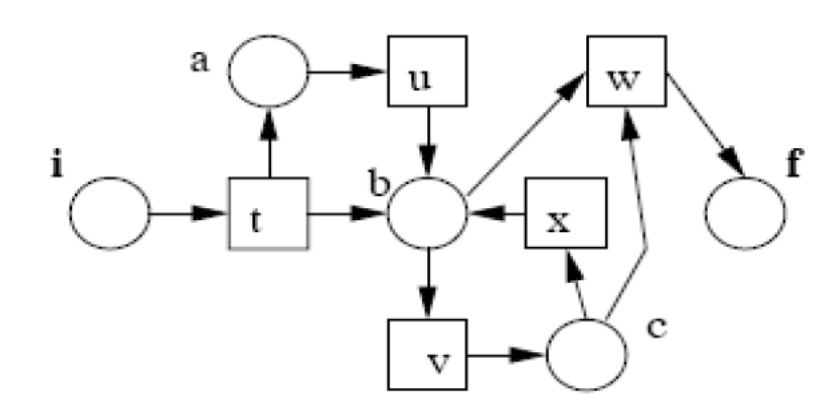
>
> #### i. Obtenha o log de eventos completo para esta rede.
>

O log pode ser expresso como na lista em Python em seguida.

In [4]:

log = [
    'tvw',
    'tuvxvw', 
    'tvxvxvw',
    'tuw', 
    'tuvxw',
    'tw' 
]


> #### ii. Utilize o algoritmo $\alpha$ para reconstruir a rede.

In [5]:

alpha = AlgoritmoAlpha()
alpha.fit(log)
alpha.summary()


 Algoritmo Alpha
 Inputs: 
 - ['t']
 Events:
 - ['t', 'u', 'v', 'w', 'x']
 Places:
 - (['t', 'u', 'v', 'x'], ['w'])
 - (['t'], ['u', 'v', 'w'])
 - (['u'], ['v'])
 Outputs:
 - ['w']
 Relationship matrix: 
       t    u    v    w    x
   t ['#', '>', '>', '>', '#']
   u ['<', '#', '>', '>', '#']
   v ['<', '<', '#', '>', '|']
   w ['<', '<', '<', '#', '<']
   x ['#', '#', '|', '>', '#']
----------------------------------------------------------------------------------------------------
 By Miguel Zanchettin


Não é possível obter a rede completa considerando o algoritmo, uma vez que ele é incapaz de perceber o loop $<v, w, v, ...>$.

>### Exercício 03
>
>O seguinte log de eventos foi obtido de um sistema de informação: 
>
>- D A G F B C
>
>- D A H F B I A G F B C
>
>- E A F H B I A F H B C
>
>- E A F G B C 
>
>- E A H F B C
>
> #### i. Utilize o algoritmo $\alpha$ para descobrir o modelo correspondente em rede de Petri.

In [6]:
log = [
    'DAGFBC',
    'DAHFBIAGFBC',
    'EAFHBIAFHBC',
    'EAFGBC',
    'EAHFBC'
]


alpha = AlgoritmoAlpha()
alpha.fit(log)
alpha.summary()


 Algoritmo Alpha
 Inputs: 
 - ['D', 'E']
 Events:
 - ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
 Places:
 - (['D', 'E', 'I'], ['A'])
 - (['F', 'G', 'H'], ['B'])
 - (['A'], ['F', 'G', 'H'])
 - (['B'], ['C', 'I'])
 Outputs:
 - ['C']
 Relationship matrix: 
       A    B    C    D    E    F    G    H    I
   A ['#', '#', '#', '<', '<', '>', '>', '>', '<']
   B ['#', '#', '>', '#', '#', '<', '<', '<', '>']
   C ['#', '<', '#', '#', '#', '#', '#', '#', '#']
   D ['>', '#', '#', '#', '#', '#', '#', '#', '#']
   E ['>', '#', '#', '#', '#', '#', '#', '#', '#']
   F ['<', '>', '#', '#', '#', '#', '|', '|', '#']
   G ['<', '>', '#', '#', '#', '|', '#', '#', '#']
   H ['<', '>', '#', '#', '#', '|', '#', '#', '#']
   I ['>', '<', '#', '#', '#', '#', '#', '#', '#']
----------------------------------------------------------------------------------------------------
 By Miguel Zanchettin


>Considere que a atividade H é invisível, ou seja, ela não é registrada no log.
>
> Utilize novamente o algoritmo $\alpha$ para verificar se é possível descobrir o modelo. 
>
> Explique o resultado.

In [7]:
log = [
    'DAGFBC',
    'DAFBIAGFBC',
    'EAFBIAFBC',
    'EAFGBC',
    'EAFBC'
]


alpha = AlgoritmoAlpha()
alpha.fit(log)
alpha.summary()


 Algoritmo Alpha
 Inputs: 
 - ['D', 'E']
 Events:
 - ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'I']
 Places:
 - (['D', 'E', 'I'], ['A'])
 - (['B'], ['C', 'I'])
 - (['A'], ['F'])
 - (['A'], ['G'])
 - (['F'], ['B'])
 - (['G'], ['B'])
 Outputs:
 - ['C']
 Relationship matrix: 
       A    B    C    D    E    F    G    I
   A ['#', '#', '#', '<', '<', '>', '>', '<']
   B ['#', '#', '>', '#', '#', '<', '<', '>']
   C ['#', '<', '#', '#', '#', '#', '#', '#']
   D ['>', '#', '#', '#', '#', '#', '#', '#']
   E ['>', '#', '#', '#', '#', '#', '#', '#']
   F ['<', '>', '#', '#', '#', '#', '|', '#']
   G ['<', '>', '#', '#', '#', '|', '#', '#']
   I ['>', '<', '#', '#', '#', '#', '#', '#']
----------------------------------------------------------------------------------------------------
 By Miguel Zanchettin


Não ocorre uma modificação tão grande na rede de Petri.

Antes, o lugar $p(A, [F, G, H])$ enviava fichas para o lugar $p([F, G, H], B)$. 

Com o novo log, $p(A, [F, G])$ transmite fichas para $p([F, G], B)$.

Uma vez que não há alteração no fluxo de passos da rede, seria impossível identificar atividades paralelas a F e G, que partam de A e sigam para B.